After writing our first super stupid and simple trading bot let us now advance into a more advanced area: SMA trading bots. 

SMA stands for Simple Moving Averages, which are kind of like "smoothed" lines of the price. Let us take a look:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime
from tqdm import tqdm

In [10]:
data = yf.download("AAPL",interval="1d",period="30d")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-12,120.400002,121.169998,119.160004,121.029999,121.029999,87963400
2021-03-15,121.410004,124.000000,120.419998,123.989998,123.989998,92403800
2021-03-16,125.699997,127.220001,124.720001,125.570000,125.570000,114740000
2021-03-17,124.050003,125.860001,122.339996,124.760002,124.760002,111437500
2021-03-18,122.879997,123.180000,120.320000,120.529999,120.529999,121229700


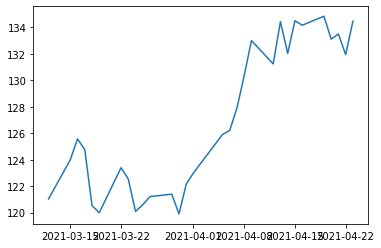

In [11]:
plt.plot(data["Close"])

## SMA explained

In [18]:
# take the average of 5 days for the close price and add it into a new column called "SMA_5"
data["SMA_5"] = data["Close"].rolling(window=5).mean()
# do the same for an average of 20 days
data["SMA_20"] = data["Close"].rolling(window=20).mean()
data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_20
Date,,,,,,,,
2021-03-12,120.400002,121.169998,119.160004,121.029999,121.029999,87963400,NaN,NaN
2021-03-15,121.410004,124.000000,120.419998,123.989998,123.989998,92403800,NaN,NaN
2021-03-16,125.699997,127.220001,124.720001,125.570000,125.570000,114740000,NaN,NaN
2021-03-17,124.050003,125.860001,122.339996,124.760002,124.760002,111437500,NaN,NaN
2021-03-18,122.879997,123.180000,120.320000,120.529999,120.529999,121229700,123.175999,NaN


## removing NAN values

why the weird nan values? As a SMA is an average over x days, the first average can only be calculated AFTER x days, which fills our array with NaN (None) values. We should remove those, and there are several different techniques for this. E.g. filling it with zeroes, or the median values of the frame. Let us go with the median route as this tends to be most stable (but causes other problems which we will discuss later).

In [20]:
data = data.fillna(data.median())
data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_20
Date,,,,,,,,
2021-03-12,120.400002,121.169998,119.160004,121.029999,121.029999,87963400,124.232001,126.199
2021-03-15,121.410004,124.000000,120.419998,123.989998,123.989998,92403800,124.232001,126.199
2021-03-16,125.699997,127.220001,124.720001,125.570000,125.570000,114740000,124.232001,126.199
2021-03-17,124.050003,125.860001,122.339996,124.760002,124.760002,111437500,124.232001,126.199
2021-03-18,122.879997,123.180000,120.320000,120.529999,120.529999,121229700,123.175999,126.199


## Visualizing the SMA values

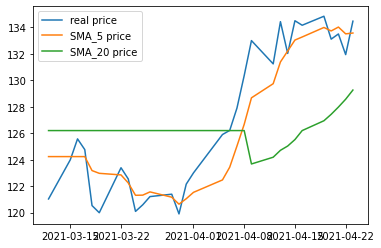

In [22]:
# let's visualize it!
plt.plot(data["Close"],label="real price")
plt.plot(data["SMA_5"],label="SMA_5 price")
plt.plot(data["SMA_20"],label="SMA_20 price")
plt.legend()

# The SMA trading strategy

One trading strategy that is quite established goes as follows: If the "fast" (shorter) SMA value crosses the "slow" (higher) SMA value, it indicates an upwards-trend. The same goes in the other direction. Meaning a trading strategy utilizing this would buy at an upwards-cross, and sell at an downwards-cross.

Let's visualize it again:

The area where the SMA_5 line is on top of the SMA_20 line is an **upwards-trend**

The are where the SMA_20 line is on top of the SMA_5 line is an **downwards-trend**

In [1]:
data = yf.download("AAPL",interval="1d",period="1y")
data["SMA_5"] = data["Close"].rolling(window=5).mean()
data["SMA_20"] = data["Close"].rolling(window=20).mean()
data = data.fillna(data.median())


plt.plot(data["Close"],label="real price")
plt.plot(data["SMA_5"],label="SMA_5 price")
plt.plot(data["SMA_20"],label="SMA_20 price")
plt.legend()

NameError: name 'yf' is not defined

# Writing a SMA trading bot

We will reuse the structure of 01_OurFirstBot for this. Keep in mind that it is full of errors that we will come to later, so do not use it in real-life!

In [38]:
# this function symbolizes the buying process of a long stock
def longBuy(crntMoney,nrStocks,crntPrice):
    # get a whole number of how many stocks we can buy with our money
    howMany = int(crntMoney/crntPrice)
    cost = howMany * crntPrice
    # substract that cost from our current Money
    crntMoney -= cost
    # add the nr of stocks we just bought to out nrStocks tracker
    nrStocks += howMany
    return crntMoney,nrStocks

def longSell(crntMoney,nrStocks,crntPrice):
    # pay out the amount of stocks times current Price
    crntMoney += nrStocks * crntPrice
    nrStocks -= nrStocks # we could set it to 0, but we want to symbolize the trade logic
    return crntMoney,nrStocks

In [39]:
# tqdm is showing us a progress bar, but basically we are just looping through our Close prices in the data array

# reset values
startMoney = 10000
crntMoney = startMoney
nrStocks = 0 

for i,(crntPrice,sma5,sma20) in enumerate(data[["Close","SMA_5","SMA_20"]].values):
    if i > 0:
        crntHoldings = nrStocks
        sma5_yesterday = data["SMA_5"][i-1]
        sma20_yesterday = data["SMA_20"][i-1]

        # start the logic
        if sma5_yesterday <= sma20_yesterday and sma5 > sma20:
            # if sma5 has been below or equal sma20 yesterday, and now it crossed upwards -> upwardstrend
            if crntHoldings == 0: # and we do not have stocks yet
                print(data.index[i]," Buying stock for %.2f$" % crntPrice)
                crntMoney,nrStocks = longBuy(crntMoney,nrStocks,crntPrice)
        elif sma5_yesterday >= sma20_yesterday and sma5 < sma20:
            # if sma5 has been above or equal sma20 yesterday, and now it crossed downwards -> downwardstrend
            if crntHoldings > 0: # can only sell if we have any stocks
                print(data.index[i]," Selling stock for %.2f$" % crntPrice)
                crntMoney,nrStocks = longSell(crntMoney,nrStocks,crntPrice)
# in the end calculate the value of our portfolio, which is the cash value (crntMoney), and the nrStocks value
portfolioValue = crntMoney + (nrStocks * crntPrice)

print("\n\nYour portfolio value is: %.2f$" % portfolioValue)
earnings = portfolioValue - startMoney
print("Which is a win of: %.2f$" % earnings)

2020-07-31 00:00:00  Buying stock for 106.26$
2020-09-09 00:00:00  Selling stock for 117.32$
2020-10-01 00:00:00  Buying stock for 116.79$
2020-10-23 00:00:00  Selling stock for 115.04$
2020-11-10 00:00:00  Buying stock for 115.97$
2020-11-25 00:00:00  Selling stock for 116.03$
2020-12-01 00:00:00  Buying stock for 122.72$
2021-01-12 00:00:00  Selling stock for 128.80$
2021-01-22 00:00:00  Buying stock for 139.07$
2021-02-12 00:00:00  Selling stock for 135.37$
2021-03-18 00:00:00  Buying stock for 120.53$
2021-03-23 00:00:00  Selling stock for 122.54$
2021-04-05 00:00:00  Buying stock for 125.90$


Your portfolio value is: 12060.01$
Which is a win of: 2060.01$


### first tweaks to our trading-framework

nice! 2060$ earnings at least in my case!
But as I stated, this will unfortunately not be the reality, as we are still ignoring a lot of errors for the sake of simplicity. But let us start by tweaking our framework step by step. 
Now we are going to add a way to symbolize the value of our portfolio

A new variable portfolioValue will be introduced tracking the current value at each day



2020-07-31 00:00:00  Buying stock for 106.26$
2020-09-09 00:00:00  Selling stock for 117.32$
2020-10-01 00:00:00  Buying stock for 116.79$
2020-10-23 00:00:00  Selling stock for 115.04$
2020-11-10 00:00:00  Buying stock for 115.97$
2020-11-25 00:00:00  Selling stock for 116.03$
2020-12-01 00:00:00  Buying stock for 122.72$
2021-01-12 00:00:00  Selling stock for 128.80$
2021-01-22 00:00:00  Buying stock for 139.07$
2021-02-12 00:00:00  Selling stock for 135.37$
2021-03-18 00:00:00  Buying stock for 120.53$
2021-03-23 00:00:00  Selling stock for 122.54$
2021-04-05 00:00:00  Buying stock for 125.90$


Your portfolio value is: 12060.01$
Which is a win of: 2060.01$


Text(0.5, 1.0, 'Portfolio Value in USD')

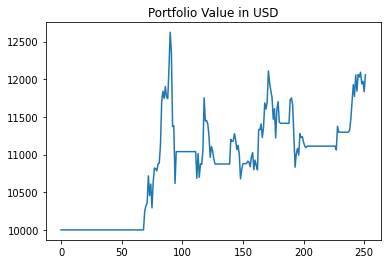

In [41]:
# tqdm is showing us a progress bar, but basically we are just looping through our Close prices in the data array

# reset values
startMoney = 10000
crntMoney = startMoney
nrStocks = 0 

## NEW: portfolioValue
portfolioValue = []

for i,(crntPrice,sma5,sma20) in enumerate(data[["Close","SMA_5","SMA_20"]].values):
    if i > 0:
        crntHoldings = nrStocks
        sma5_yesterday = data["SMA_5"][i-1]
        sma20_yesterday = data["SMA_20"][i-1]

        # start the logic
        if sma5_yesterday <= sma20_yesterday and sma5 > sma20:
            # if sma5 has been below or equal sma20 yesterday, and now it crossed upwards -> upwardstrend
            if crntHoldings == 0: # and we do not have stocks yet
                print(data.index[i]," Buying stock for %.2f$" % crntPrice)
                crntMoney,nrStocks = longBuy(crntMoney,nrStocks,crntPrice)
        elif sma5_yesterday >= sma20_yesterday and sma5 < sma20:
            # if sma5 has been above or equal sma20 yesterday, and now it crossed downwards -> downwardstrend
            if crntHoldings > 0: # can only sell if we have any stocks
                print(data.index[i]," Selling stock for %.2f$" % crntPrice)
                crntMoney,nrStocks = longSell(crntMoney,nrStocks,crntPrice)
        ## NEW: portfolioValue -> use the same logic as our previous final caluclation, just for each day
        portfolioValue.append(crntMoney + (nrStocks * crntPrice))

print("\n\nYour portfolio value is: %.2f$" % portfolioValue[-1])
earnings = portfolioValue[-1] - startMoney
print("Which is a win of: %.2f$" % earnings)

plt.plot(portfolioValue)
plt.title("Portfolio Value in USD")